In [1]:
import os
os.chdir('/Users/prakriti/2025_RP_phases/phonons')
from ase.spacegroup.symmetrize import FixSymmetry
import mplpub
import warnings
mplpub.setup(template='acs')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import numpy as np
from ase.io import read
from calorine.calculators import CPUNEP
from calorine.tools import get_force_constants, relax_structure
from matplotlib import pyplot as plt
from pandas import DataFrame
from phonopy.units import THzToCm
from seekpath import get_explicit_k_path
import phonopy

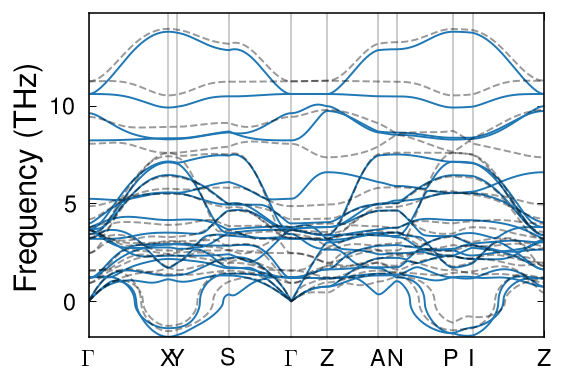

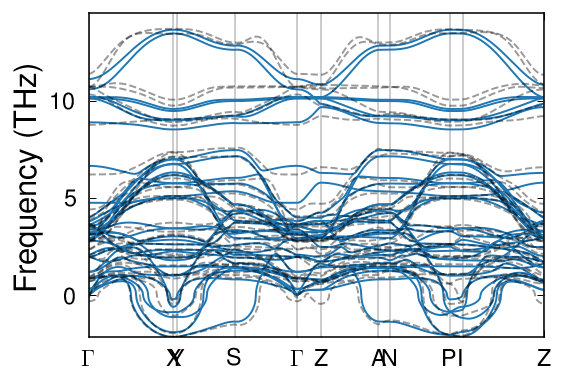

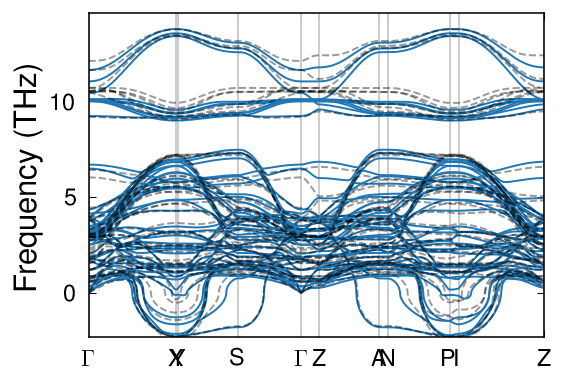

In [5]:
for n in range(1,4):
    structure = read(f'RP_{n}_000_000_primitive.in')
    calculator = CPUNEP('../nep.txt')
    structure.calc = calculator
    structure.set_constraint(FixSymmetry(structure))
    relax_structure(structure, fmax=0.0001)
    phonon = get_force_constants(structure, calculator, [2,2,2])
    structure_tuple = (structure.cell, structure.get_scaled_positions(), structure.numbers)
    a = structure.cell[:][0][0]
    c = structure.cell[:][2][2]
    eta = (1 + a**2/c**2)/4
    xi = a**2/(2*c**2)
    path = "GXYSGZANPIZ"
    special_points = dict(
        G = [0,0,0],
        X = [0,0,0.5],
        Y = [-xi, -xi, 0.5],
        S = [-eta, eta, eta],
        Z = [1/2, 1/2, -1/2],
        A = [eta, 1-eta, -eta],
        N = [0, 1/2, 0],
        P = [1/4, 1/4, 1/4],
        I = [1/2, 1/2, -xi], 
    
    )
    path_list = []
    for start, stop in zip(path[:-1], path[1:]):
        start = special_points[start]
        stop = special_points[stop]
        path_list.append(np.linspace(start, stop, 100))
    
    phonon.run_band_structure(path_list)
    band = phonon.get_band_structure_dict()
    phonopy_paths, phonopy_dists, phonopy_freqs, *_ = phonon.get_band_structure()

    phonon_DFT = phonopy.load(f'/Users/prakriti/2025_RP_phases/phonons/n{n}_I4_mmm_DFT/phonopy.yaml', force_sets_filename=f'/Users/prakriti/2025_RP_phases/phonons/n{n}_I4_mmm_DFT/FORCE_SETS')
    phonon_DFT.run_band_structure(path_list)
    band_DFT = phonon.get_band_structure_dict()
    phonopy_paths_DFT, phonopy_dists_DFT, phonopy_freqs_DFT, *_ = phonon_DFT.get_band_structure() 
    
    fig, ax = plt.subplots(figsize=(4.2, 3), dpi=140)
    ax.set_ylabel('Frequency (THz)', fontsize=16)
    
    xticks = [d[0] for d in phonopy_dists] + [phonopy_dists[-1][-1]]
    labels = [r'$\UG{\Gamma}$' if m == 'G' else m for m in list(path)]
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    for xp in xticks:
        ax.axvline(xp, color='0.8')
    
    ax.plot(np.hstack(phonopy_dists), np.vstack(phonopy_freqs), color='tab:blue')
    ax.plot(np.hstack(phonopy_dists), np.vstack(phonopy_freqs_DFT), color='black', alpha = 0.4, linestyle='--')
    ax.set_xlim(np.hstack(phonopy_dists).min(),np.hstack(phonopy_dists).max())
    ax.set_ylim(np.vstack(phonopy_freqs).min())
    ax.tick_params(labelsize=12)
    fig.savefig(f'../figs/RP_{n}_I4_mmm_phonons.png', bbox_inches='tight')